# NanoFTIR data visualization and processing workflow

This notebook helps you to quickly visualize nanoFTIR measurements including their location on the Whitelight or AFM images that were used to select point locations.

### Important notes:

The code assumes the basic folder structure of the neaspec files directly downloaded from the instrument.

## Import neccesarry packages

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import os, sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

import pySNOM
from pySNOM import readers
from pySNOM import images
from pySNOM.spectra import NeaSpectrum

import plotly.graph_objects as go

## Get the file names

To automatically read and plot all the files, this code snippet runs through all the subfolders in the given folder.

The folder has to contain the subfolders for spectral measurements, plus at least one additional folder with the afm or whitelight map used to pick the locations for the point spectra.

Getting spectrum file names:

```python
spectra_filenames = get_filenames(folder, pattern="NF S NORM")
```

´pattern´ argument is able to filter for files. NeaSpec's naming conventions if the following:
- NF S: single beam spectrum
- NF S NORM: normallized spectra
- Interferograms: the raw interferogram

Important to note that the to get the "NF S NORM" spectra upon data download, you have to apply a reference spectrum already in the NeaSCAN software.

```python
wl_imagenames = get_filenames(folder,pattern=" O2A raw")
```

In order to search for an image .GSF file, you have to looks for a specific data channel. Here, in this example, we look for a file with ` O2A raw`in its name to get the whitelight image from our folder


In [ ]:
import os
import re

folder = "YOUR_FOLDER_PATH_HERE"

def get_filenames(location_folder, pattern = "NF S NORM"):
    """ Returns the full filepath of the choosen measurement files in a location folder (assuming neaspec file structure)"""

    spectrum_filepaths = []

    for folder in os.listdir(location_folder):
        subfolder = os.path.join(location_folder, folder)
        if os.path.isdir(subfolder):
            for name in os.listdir(subfolder):
                if re.search(pattern,name):
                    subpath = os.path.join(folder,name)
                    spectrum_filepaths.append(os.path.join(location_folder,subpath))

    return spectrum_filepaths

spectra_filenames = get_filenames(folder, pattern="NF S NORM")
wl_channel = "O2A raw"
wl_imagenames = get_filenames(folder,pattern=f" {wl_channel}")

print(f"{len(spectra_filenames)} spectra found.")
print(f"{len(wl_imagenames)} images found.")

# If multiple image found, you have to choose one
wl_imagenames = wl_imagenames[-1]

8 spectra found.
2 images found.


### Read all the spectra

In [ ]:
spectra = []
for f in spectra_filenames:
    data_reader = readers.NeaSpectralReader(f)
    data, measparams = data_reader.read()
    s = NeaSpectrum(data,measparams,filename=f)
    spectra.append(s)

### Read the image

In [ ]:
data_reader = readers.GsfReader(wl_imagenames)
wlimage = data_reader.read()

### Image corrections

In [ ]:
ll = images.LineLevel(method="median",datatype=images.DataTypes.Amplitude)
wlimage.data = ll.transform(wlimage.data)

## Create a complete plot with both the amplitude and phase spectra and the image with the locations

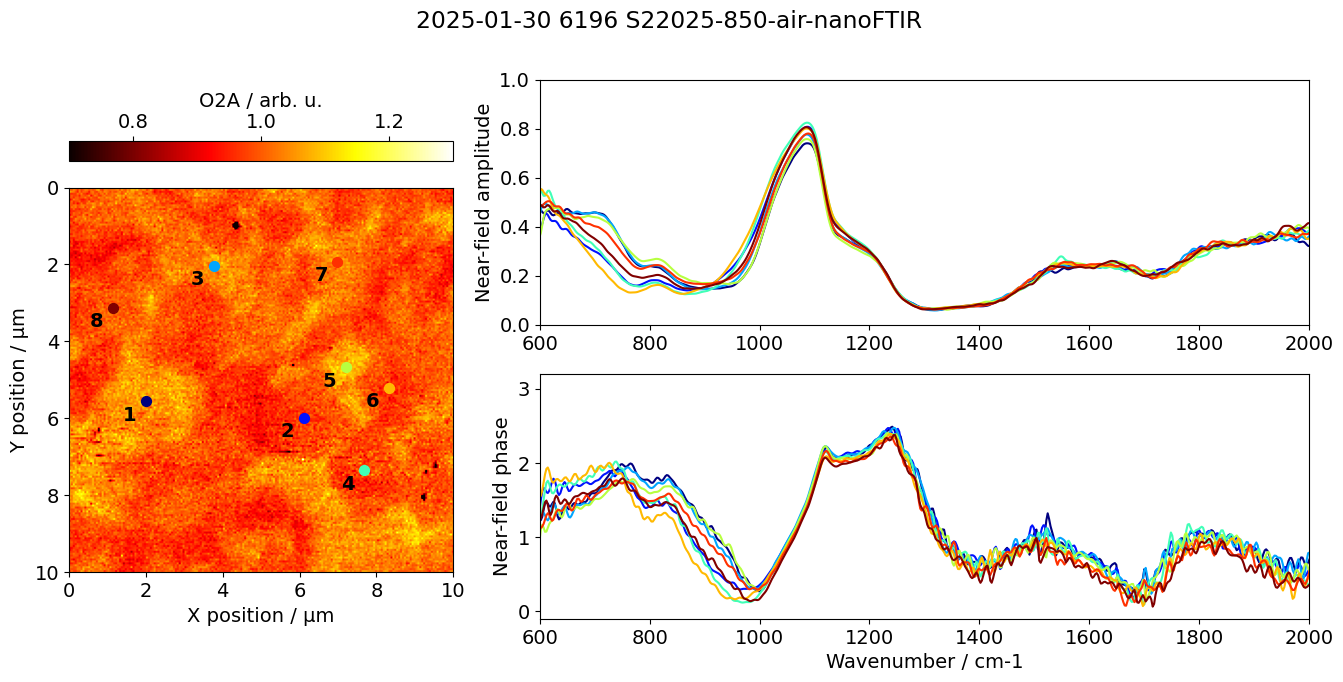

In [ ]:
# Choose which channel to plot from the spectra
order = 2
channelA = f"O{order}A"
channelP = f"O{order}P"

plt.rcParams.update({'font.size': 14})
# Plot image
xmin = (0)*1e6
xmax = (wlimage.xreal)*1e6
ymin = (wlimage.yreal)*1e6
ymax = (0)*1e6

# take the spectrum positions
xpos = []
ypos = []
point_labels = []
for i,s in enumerate(spectra):
    xpos.append(s._parameters["ScannerCenterPosition"][0]-(wlimage.xoff)*1e6)
    ypos.append(s._parameters["ScannerCenterPosition"][1]-(wlimage.yoff)*1e6)
    point_labels.append(str(i+1))

# Prepare figure
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1600*px, 700*px))
fig.suptitle(folder)

cmap = mpl.colormaps['jet']
colors = cmap(np.linspace(0, 1, len(spectra)))

# Prepare subplot placement
gs = fig.add_gridspec(2,2,width_ratios=[1,2],wspace=0.15)
axs = [fig.add_subplot(gs[:,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[1,1])]

# WhiteLight image
mid = np.median(wlimage.data)
im1 = axs[0].imshow(wlimage.data, extent=[xmin, xmax, ymin, ymax], cmap=mpl.colormaps['hot'], vmin=0.7*mid,vmax=1.3*mid)
cbar = fig.colorbar(im1, ax = axs[0], label = f"{wl_channel} / arb. u.", shrink=1, location='top')

# Add point positions and labels
axs[0].set(xlabel = 'X position / μm', ylabel = 'Y position / μm')
for i in range(len(xpos)):
    axs[0].scatter(x = xpos[i], y = ypos[i], s=50, color=colors[i])
    axs[0].text(xpos[i]-0.6,ypos[i]+0.5,point_labels[i],color="black",weight='bold')

# Plot the amplitude and phase spectra
for index, s in enumerate(spectra):
    axs[1].plot(s.data["Wavenumber"],s.data[channelA],color=colors[index])
    axs[2].plot(s.data["Wavenumber"],s.data[channelP],color=colors[index])

# AXES labels and settings
axs[1].sharex(axs[2])
axs[1].set_ylabel(f"Near-field amplitude")
axs[1].set_ylim(0.0, 1.)
axs[2].set_xlim(600, 2000)
axs[2].set_xlabel("Wavenumber / cm-1")
axs[2].set_ylim(-0.1, 3.2)
axs[2].set_ylabel(f"Near-field phase")
# axs[1].label_outer()

plt.show()